### Importing Dependencies

In [1]:
import cv2 
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## Setup GPU Growth

In [3]:
# Avoid Out of Memory error by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Create Folder Structure

In [5]:
#Setup paths

POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH)

## Collect positives and Anchors

In [7]:
# Images collected from the following link: 
# http://vis-www.cs.umass.edu/lfw/

In [8]:
# #Uncompress the Tar GZ Labelled Faces in the Wild Dataset
# !tar -xf lfw.tgz

In [9]:
# # Move LFW Images to the following repository data/negative

# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

### Collect positive and anchor classes

In [10]:
# to generate unique image names
import uuid

# Count the number of anchor and positive images
# current state: anch=453, pos=373 
pos=0
anch=0

In [11]:
# Connect to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #cut down frame to 250x250px size
    frame = frame[120:120+250,200:200+250,:]
    
    #collect anchors
    if cv2.waitKey(0) & 0XFF == ord('a'):
        anch+=1
        #create unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
        
    
    #collect positives
    if cv2.waitKey(0) & 0XFF == ord('p'):
        pos+=1
        #create unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #Write out anchor image
        cv2.imwrite(imgname, frame)
        
        
    
    #show image back to the screen 
    cv2.imshow('Collecting Images', frame)

    if cv2.waitKey(0) & 0XFF == ord('q'):
        print("Number of Anchor Images Collected: ", anch)
        print("Number of Positive Images Collected: ", pos)
        break
        
# Release the webcam        
cap.release()
#Close the image show frame
cv2.destroyAllWindows()

Number of Anchor Images Collected:  0
Number of Positive Images Collected:  0


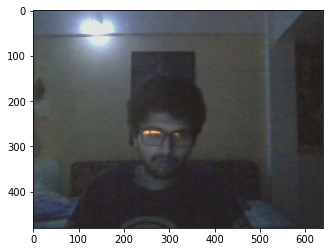

In [16]:
plt.imshow(frame)

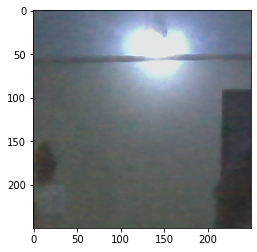

In [19]:
plt.imshow(frame[:250,:250,:])

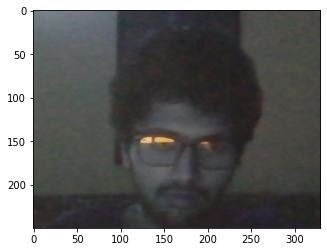

In [24]:
plt.imshow(frame[120:120+250,120:200+250,:])

## Load and Preprocess Images

In [11]:
# Data Augmentation

In [12]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data


In [13]:
import uuid

### Get Image Directories

In [ ]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [14]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2022-07-21 03:29:27.532531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-21 03:29:28.014171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1617 MB memory:  -> device: 0, name: NVIDIA GeForce MX250, pci bus id: 0000:02:00.0, compute capability: 6.1


In [15]:
#testing
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/aa63253b-059a-11ed-84ed-f3b18b0bf457.jpg'


### Preprocessing - Resizing and Scaling   

In [16]:
def preprocess(file_path):
    
    #Read image from file path
    byte_img = tf.io.read_file(file_path)
    
    #Loading the image
    img = tf.io.decode_jpeg(byte_img)
    
    
    # Preprocessing Steps
    
    #Resizing image to 100x100
    img = tf.image.resize(img, (100,100))
    
    #Scaling image between 0 and 1
    img = img/255.0
    return img

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
#testing
samples = data.as_numpy_iterator()

In [19]:
samples.next()

(b'data/anchor/a5cd693b-059a-11ed-84ed-f3b18b0bf457.jpg',
 b'data/positive/df495a9e-07b0-11ed-836b-03101e883d9b.jpg',
 1.0)

### Build the train and test partition

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
#Testing
example = samples.next()
# Note: The star before example is used for unpacking the values in each tuple
res = preprocess_twin(*example)

In [22]:
#Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [34]:
samples = data.as_numpy_iterator()

In [39]:
samp = samples.next()

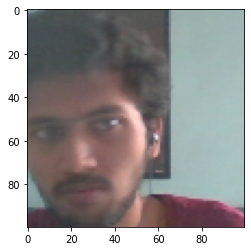

In [40]:
plt.imshow(samp[0])

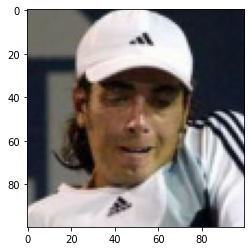

In [41]:
plt.imshow(samp[1])

In [42]:
samp[2]

0.0

### Partitioning the data

In [43]:
# 70% of data will be used for training
round(len(data)*.7)

420

In [23]:
# Training partition
train_data = data.take(420)
train_data = train_data.batch(4)
train_data = train_data.prefetch(2)

In [24]:
train_samples = train_data.as_numpy_iterator()

In [25]:
train_sample = train_samples.next()

2022-07-21 03:29:59.568989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 501 of 1024
2022-07-21 03:30:02.135731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


In [47]:
len(train_sample)

3

In [48]:
len(train_sample[0])

4

In [26]:
# Test partition
test_data = data.skip(420)
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(3)
test_data = test_data.prefetch(2)

## Model Engineering

### - Build Embedding Layer

In [27]:
inp = Input(shape=(100,100,3), name='Input Image') # 100x100x3

In [72]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'Input Image')>

In [73]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [74]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [75]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [76]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [77]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)

In [78]:
c2

<KerasTensor: shape=(None, 40, 40, 128) dtype=float32 (created by layer 'conv2d_1')>

In [79]:
m2 = MaxPooling2D(64,(2,2), padding='same')(c2)

In [80]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [81]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)

In [82]:
c3

<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_2')>

In [83]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [84]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [85]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)

In [86]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_3')>

In [87]:
f1 = Flatten()(c4)

In [88]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten')>

In [89]:
d1 = Dense(4096, activation='sigmoid')(f1)

In [90]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense')>

In [91]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [92]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [28]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='Input Image') # 100x100x3
    
    # First Block
    c1 = Conv2D(64,(10,10), activation='relu')(inp)  # 91x91x64
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # 46x46x64
    
    #Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1) # 40x40x128
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2) #20x20x128
    
    #Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)   # 17x17x128
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3) # 9x9x128 
    
    # Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3) # 6x6x256
    f1 = Flatten()(c4)                             # 9216
    d1 = Dense(4096, activation='sigmoid')(f1)     # 4096
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [29]:
embedding = make_embedding()

In [30]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

### Build Distance Layer

In [31]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    #Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    #Similarity Calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [32]:
l1 = L1Dist()

In [33]:
def make_siamese_model():
    
    #Anchor Image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    #Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    #Combine siamese distance compponents
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [34]:
siamese_model = make_siamese_model()

In [35]:
siamese_model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

## Training

In [36]:
## Setup Loss and Optimizer

binary_cross_loss = tf.losses.BinaryCrossentropy()
# Setting logits=True in the loss function is recommended when the inputs to the loss function are not normalised

opt = tf.keras.optimizers.Adam(1e-4) 

In [37]:
## Establishing checkpoint directory

checkpoint_dir = './training_chkpts'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [38]:
## Build Train Step Function

@tf.function
# Note: here tf.function is used to compile our function into a callable Tensorflow graph
# You need to have this decorator whenever you're creating your trainer function outside 
# of a consolidated or compiled model
def train_step(batch):
    
    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative images
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        # Note: Don't forget to set training=True whenever you're doing the training part
        # Since doing that will activate the layers and other functions like dropout required for training 

        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model 
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [39]:
# Build training loop

def train(data, EPOCHS, manager):
    
    # Restore to the latest checkpoint
    checkpoint.restore(manager.latest_checkpoint)
    
    # Printing if checkpoint is latest or not
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")

    
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run the train step 
            loss = train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 == 0:
            save_path = manager.save()
            print("Saved checkpoint for step: {}".format(epoch))
            #checkpoint.save(file_prefix=checkpoint_prefix)

### Train the model

In [40]:
EPOCHS = 50

In [41]:
# Setting manager to get the latest checkpoint
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [ ]:
train(train_data, EPOCHS, manager)

## Restoring the model from the latest checkpoint

In [42]:
checkpoint.restore(manager.latest_checkpoint)

2022-07-21 03:30:33.767340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2022-07-21 03:30:38.242698: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2022-07-21 03:30:41.558240: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


## Evaluate Model

In [43]:
from tensorflow.keras.metrics import Precision, Recall

In [44]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [45]:
r1 = 0
r2 = 0
count = 0

In [46]:
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    count += 1
    
    y_hat = siamese_model.predict([test_input, test_val])
    # Creating a metric object
    m = Recall()

    # Calculating the recall value
    v1 = m.update_state(y_true, y_hat)

    # Return Recall result
    r1 += m.result().numpy()
    
    # Creating a metric object
    m = Precision()

    # Calculating the recall value
    v2 = m.update_state(y_true, y_hat)

    # Return Precision result
    r2 += m.result().numpy()

2022-07-21 03:31:01.159151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-21 03:31:11.352179: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 03:31:11.423213: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 03:31:11.423291: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-21 03:31:11.482150: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-21 03:31:11.482425: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-21 03:31:19.993216: I tensorflow/stream_executor/cuda/c

1/1 [==============================] - 0s 18ms/step


In [47]:
r1/count

0.9

In [48]:
r2/count

0.9

In [49]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 20ms/step


array([[6.5052110e-09],
       [9.9435234e-01],
       [1.0766467e-10]], dtype=float32)

In [50]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0]

In [51]:
y_true.astype(int)

array([0, 1, 0])

### Calculating Recall

In [52]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall result
m.result().numpy()

1.0

### Calculating Precision

In [53]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Precision result
m.result().numpy()

1.0

### Visualising Prediction Results

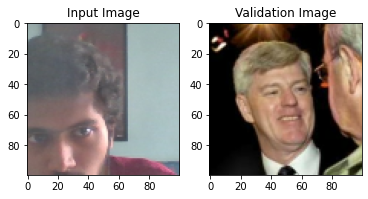

Output: 0.0


In [54]:
#Setting index value
i = 2

# Plotting Input Image
plt.subplot(1,2,1)
plt.imshow(test_input[i])
plt.title('Input Image')

#Plotting Validation Image
plt.subplot(1,2,2)
plt.imshow(test_val[i])
plt.title('Validation Image')

plt.show()

# Outputting the prediction
print('Output: {}'.format(y_true[i]))

### Save Model

In [55]:
# Save model
siamese_model.save('siamesemodel1.h5')

2022-07-21 03:32:00.732279: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


In [81]:
# The save_weights() method can be used to the save the weights only. (Use load_weights() to load weights only)
# The save() method saves the optimizer state as well

### Reload model

In [ ]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})
# Note: We are entering custom_objects since we have made our own custom objects and must specify that while
#       loading the model. otherwise it will cause errors

# Real Time Test

In [72]:
model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

In [56]:
# Verification function

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
        
    # Detection threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return verification, verified 

In [57]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verifying', frame)
    
    # Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification 
        verification, results  = verify(siamese_model, 0.9, 0.7)
        print(verification)
        print(results)
        
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to target thread (0x55bf3e91fb00)

QObject::moveToThread: Current thread (0x55bf3e91fb00) is not the object's thread (0x55bf3b0a7d10).
Cannot move to tar

1/1 [==============================] - 0s 18ms/step


2022-07-21 03:33:00.143739: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 283.59MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 19ms/step
0.6746987951807228
False
1/1 [==============================] - 0s 17ms/step
0.7469879518072289
True
1/1 [==============================] - 0s 17ms/step
0.7108433734939759
True
1/1 [==============================] - 0s 17ms/step
0.8192771084337349
True
1/1 [==============================] - 0s 17ms/step
0.8072289156626506
True
1/1 [==============================] - 0s 17ms/step
0.7108433734939759
True


In [109]:
input_img = preprocess(os.path.join('data', 'negative', 'Adrien_Brody_0008.jpg'))
input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
validation_img = preprocess(os.path.join('application_data', 'verification_images', "c9b91428-059b-11ed-84ed-f3b18b0bf457.jpg"))

In [110]:
result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))

1/1 [==============================] - 0s 15ms/step


In [111]:
result

array([[0.9999999]], dtype=float32)

In [112]:
result > 0.5

array([[ True]])